In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import os
import random
import PIL
import tensorflow as tf
from tensorflow.keras.layers import Activation, Dense, Flatten, Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input, decode_predictions, ResNet50
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img, array_to_img
import seaborn as sns

2024-05-03 06:29:44.117006: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 06:29:44.117108: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 06:29:44.395456: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


This study aims to classify 

In [2]:
import os
import shutil
import random

data_dir = "/kaggle/input/flowers-recognition/flowers"


train_dir = "path/to/your/train_data"
test_dir = "path/to/your/test_data"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)


classes = os.listdir(data_dir)


train_ratio = 0.90


for cls in classes:
    class_dir = os.path.join(data_dir, cls)
    images = os.listdir(class_dir)
    random.shuffle(images)
    train_size = int(len(images) * train_ratio)
    train_images = images[:train_size]
    test_images = images[train_size:]


    for img in train_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(train_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

    for img in test_images:
        src = os.path.join(class_dir, img)
        dst = os.path.join(test_dir, cls, img)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.copy(src, dst)

print("Train-test split completed successfully.")

Train-test split completed successfully.


In [3]:
# Kinds of flowers
kinds = np.array(os.listdir('/kaggle/input/flowers-recognition/flowers'))
print(f"Flower kinds in dataset: {kinds}")

Flower kinds in dataset: ['dandelion' 'daisy' 'sunflower' 'tulip' 'rose']


In [4]:
# Paths of directories
path = '/kaggle/input/flowers-recognition/flowers'
kind_path = [path + "/" + flower for flower in kinds]
kind_path

['/kaggle/input/flowers-recognition/flowers/dandelion',
 '/kaggle/input/flowers-recognition/flowers/daisy',
 '/kaggle/input/flowers-recognition/flowers/sunflower',
 '/kaggle/input/flowers-recognition/flowers/tulip',
 '/kaggle/input/flowers-recognition/flowers/rose']

In [5]:
# Numbers of flowers for each kinds
for i, kind in enumerate(kind_path):
    print(f"There are {len(os.listdir(kind))} flowers in {kinds[i]}")

There are 1052 flowers in dandelion
There are 764 flowers in daisy
There are 733 flowers in sunflower
There are 984 flowers in tulip
There are 784 flowers in rose


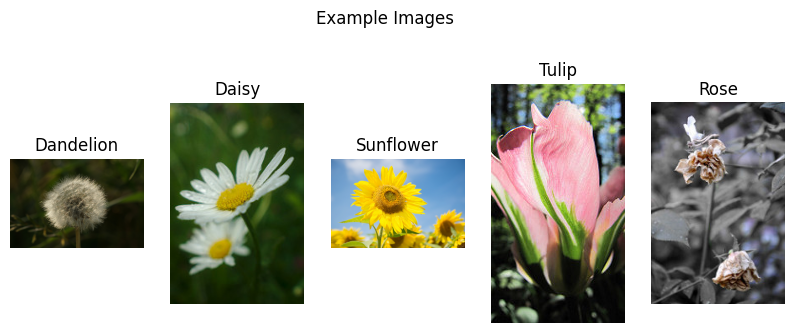

In [6]:
# Example images for each kinds
plt.figure(figsize=(10,4))
plt.suptitle("Example Images")
for i, kind in enumerate(kinds):
    ax = plt.subplot(1, 5, i+1)
    path = kind_path[i] + "/" + os.listdir(kind_path[i])[1]
    img = plt.imread(path)
    plt.imshow(img)
    plt.title(kind.capitalize())
    plt.axis("off")

In [7]:
# All ids
id_df = []
for i in range(len(kinds)):
    id = [img.split(".")[0] for img in os.listdir(kind_path[i])]
    id_df = id_df + id
len(id_df)

4317

In [8]:
# All kinds
kind_df = []
for i, kind in enumerate(kinds):
    for x in range(len(os.listdir(kind_path[i]))):
        kind_df.append(kind)
len(kind_df)

4317

In [9]:
# Create a dataframe
df = pd.DataFrame(columns=["id", "kind"])
df["id"] = id_df
df["kind"] = kind_df
df.tail()

,id,kind
4312,7820626638_3e2d712303,rose
4313,5148639829_781eb7d346,rose
4314,5335946401_f49bfbe3f9_n,rose
4315,8063462557_e0a8bd6c64_n,rose
4316,2536282942_b5ca27577e,rose


In [10]:
# Check numbers
df["kind"].value_counts(normalize = True)

kind
dandelion    0.243688
tulip        0.227936
rose         0.181608
daisy        0.176975
sunflower    0.169794
Name: proportion, dtype: float64

In [11]:
filenames = []
for i in range(len(kinds)):
    file = [kind_path[i] + "/" + kind for kind in os.listdir(kind_path[i])]
    filenames = filenames + file
filenames[:5]

['/kaggle/input/flowers-recognition/flowers/dandelion/34578947551_863af3acb3_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/2625836599_03e192266f.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/16242239484_51286673af.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/5716633491_55e6f02645_n.jpg',
 '/kaggle/input/flowers-recognition/flowers/dandelion/34697163155_5dc2571f23_n.jpg']

In [12]:
# Check a random flower
print(filenames[2317])
print(df.loc[2317])

/kaggle/input/flowers-recognition/flowers/sunflower/8174935013_b16626b49b.jpg
id      8174935013_b16626b49b
kind                sunflower
Name: 2317, dtype: object


In [14]:
boolean_kinds = [kind == kinds for kind in kind_df]
boolean_kinds[:5]

[array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False]),
 array([ True, False, False, False, False])]

# **Train and Test Split**

In [15]:
X = filenames
y = boolean_kinds

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.1,
                                                    random_state=1,
                                                   stratify = y)
len(X_train), len(X_test), len(y_train), len(y_test)

(3885, 432, 3885, 432)

# **Image Preprocessing**

In [17]:
image = imread(filenames[1])
image.shape

(333, 500, 3)

In [18]:
# turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 500, 3), dtype=uint8, numpy=
array([[[38, 30, 11],
        [38, 30, 11],
        [38, 30, 11],
        ...,
        [30, 37,  6],
        [31, 36,  6],
        [31, 36,  4]],

       [[38, 30, 11],
        [38, 30, 11],
        [37, 29, 10],
        ...,
        [31, 38,  5],
        [31, 38,  5],
        [33, 38,  6]]], dtype=uint8)>

In [19]:
# Create a function for preprocessing images
def process_image(image_path, img_size=256):
  # Read in an image file
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 colour channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Convert the colour channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, 256])

  return image

In [20]:
process_image(X[17]), tf.constant(y[17])

(<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
 array([[[0.04313726, 0.03137255, 0.01176471],
         [0.04339067, 0.03162597, 0.01201812],
         [0.04500248, 0.03323777, 0.01362993],
         ...,
         [0.03379289, 0.02987133, 0.01026348],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04583136, 0.03406665, 0.01445881],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03337821, 0.02945665, 0.0098488 ],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        [[0.04313726, 0.03137255, 0.01176471],
         [0.04410999, 0.03234528, 0.01273744],
         [0.04705883, 0.03529412, 0.01568628],
         ...,
         [0.03287378, 0.02895221, 0.00934436],
         [0.03529412, 0.03137255, 0.01176471],
         [0.03529412, 0.03137255, 0.01176471]],
 
        ...,
 
        [[0.45161214, 0.35360354

# **Data Augmentation**

In [21]:
image_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split = 0.2,
    rescale = 1/255
)

In [22]:
batch_size = 32
img_height = 256
img_width = 256

In [23]:
training_data = image_gen.flow_from_directory(
    train_dir,
    subset = "training",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

validation_data = image_gen.flow_from_directory(
    train_dir,
    subset = "validation",
    class_mode="categorical",
    target_size = (img_width, img_height),
    batch_size = batch_size,
    shuffle = False
)

Found 3107 images belonging to 5 classes.
Found 775 images belonging to 5 classes.


In [24]:
image_shape = (256,256,3)

# **CNN Model**

In [25]:
# to select the weights for the epoch with the highest val_score

class GetBestModel(tf.keras.callbacks.Callback):
    def __init__(self, monitor = "val_loss", verbose = 0, mode = "auto"):
        super(GetBestModel, self).__init__()
        self.monitor = monitor
        self.verbose = verbose
        self.mode = mode
        if self.mode == "min":
            self.best = np.Inf
        else:
            self.best = -np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if self.mode == "min" and current < self.best:
            self.best = current
            self.best_weights = self.model.get_weights()
        elif self.mode == "max" and current > self.best:
            self.best = current
            self.best_weights = self.model.get_weights()

    def on_train_end(self, logs=None):
        self.model.set_weights(self.best_weights)

In [26]:
best_model = GetBestModel(monitor = "val_loss", mode = "min", verbose = 1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [27]:
model = Sequential()

model.add(Conv2D(filters=128, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 127, 127, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 62, 62, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 30, 30, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       589,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,368,645 (9.04 MB)

 Trainable params: 2,366,597 (9.03 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [28]:
results = model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks = [early_stop, best_model])

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1714718028.108841      90 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1714718028.136725      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/98 ━━━━━━━━━━━━━━━━━━━━ 4s 551ms/step - accuracy: 0.2070 - loss: 1.7817

W0000 00:00:1714718077.411511      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 528ms/step - accuracy: 0.2071 - loss: 1.7722

W0000 00:00:1714718081.686040      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 130s 718ms/step - accuracy: 0.2071 - loss: 1.7711 - val_accuracy: 0.1768 - val_loss: 1.6194
Epoch 2/5


W0000 00:00:1714718097.985350      89 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 512ms/step - accuracy: 0.2367 - loss: 1.6101 - val_accuracy: 0.2284 - val_loss: 1.5994
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 511ms/step - accuracy: 0.2131 - loss: 1.6053 - val_accuracy: 0.2439 - val_loss: 1.5957
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 509ms/step - accuracy: 0.2531 - loss: 1.6041 - val_accuracy: 0.2439 - val_loss: 1.5934
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 53s 504ms/step - accuracy: 0.2050 - loss: 1.6080 - val_accuracy: 0.2671 - val_loss: 1.5857


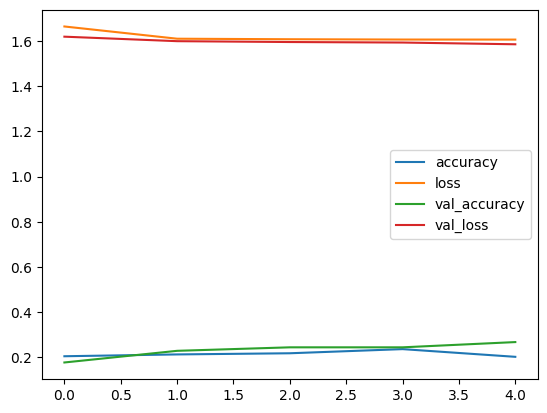

In [38]:
pd.DataFrame(results.history).plot();

In [29]:
summary = pd.DataFrame(model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.204377,1.664517,0.176774,1.619356
1,0.212424,1.610335,0.228387,1.599449
2,0.217573,1.608009,0.243871,1.595665
3,0.235919,1.606657,0.243871,1.593399
4,0.201802,1.606467,0.267097,1.585698


In [39]:
preds = model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step
[1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 4 1 1 4 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1
 4 1 1 1 1 4 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1
 1 4 1 1 1 1 4 4 4 1 1 1 1 1 1 1 1 1 4 1 1 1 4 4 1 4 1 1 1 1 1 1 1 1 1 1 1
 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 4
 1 1 1 1 1 1 4 4 4 1 1 1 1 1 4 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 4 4 1 1 1 1 4 1 1 1 1 4 1 4 1 1 1 1
 1 4 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 4 1 1 1 4 4 4 1 1
 4 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 4 1 1 4 4 1 1 1 1 1 4 1 1 1 1 4
 4 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 4 1 1 4 1 1 4 1 1 4 1 1 1 1 1 1 4
 1 1 1 1 1 1 1 1 4 1 1 1 4 1 1 1 1 4 4 1 4 1 4 1 1 1 1 1 1 1 1 1 1 4 1 1 1
 4 1 1 1 1 1 1 1 1 4 1 1 1 1 1 4 1 4 1 1 4 1 1 4 1 1 1 1 4

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# **Xception Model**

In [40]:
xception_model = Sequential()

pretrained_model= tf.keras.applications.Xception(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

xception_model.add(pretrained_model)
xception_model.add(Flatten())
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(512, activation='relu'))
xception_model.add(Dense(5, activation='softmax'))
xception_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

xception_model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ ?                      │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [41]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = xception_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop, best_model]])

Epoch 1/5
 1/98 ━━━━━━━━━━━━━━━━━━━━ 48:06 30s/step - accuracy: 0.0312 - loss: 1.6788

W0000 00:00:1714718970.718525      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/98 ━━━━━━━━━━━━━━━━━━━━ 21s 497ms/step - accuracy: 0.2252 - loss: 1.8118

W0000 00:00:1714718997.092329      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.3149 - loss: 1.6084

W0000 00:00:1714719017.452729      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 92s 644ms/step - accuracy: 0.3162 - loss: 1.6051 - val_accuracy: 0.6310 - val_loss: 0.7865
Epoch 2/5


W0000 00:00:1714719033.320661      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 502ms/step - accuracy: 0.6826 - loss: 0.8038 - val_accuracy: 0.7394 - val_loss: 0.6094
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 494ms/step - accuracy: 0.7832 - loss: 0.6134 - val_accuracy: 0.7523 - val_loss: 0.6110
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 504ms/step - accuracy: 0.8081 - loss: 0.5683 - val_accuracy: 0.8052 - val_loss: 0.5626
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 52s 500ms/step - accuracy: 0.8212 - loss: 0.4911 - val_accuracy: 0.8568 - val_loss: 0.4490


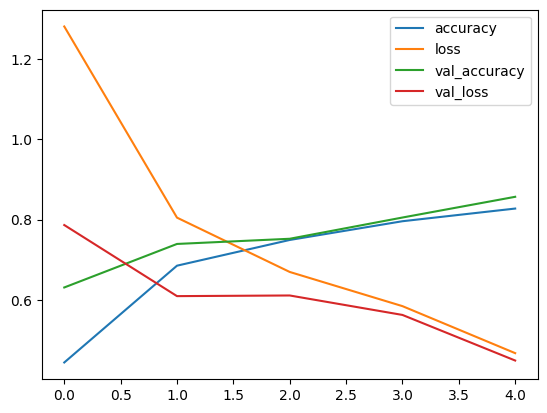

In [42]:
pd.DataFrame(results.history).plot();

In [43]:
summary = pd.DataFrame(xception_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.444158,1.280972,0.630968,0.786453
1,0.685227,0.804893,0.739355,0.609410
2,0.749276,0.669607,0.752258,0.611021
3,0.795945,0.584479,0.805161,0.562565
4,0.827486,0.467390,0.856774,0.449010


In [48]:
preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 409ms/step
[0 0 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 0 0 0 4 0 0 0 0 0 0 0 0 4 0 0 0 0 1 0 1 0 0 0 4 0 0 0 0 0 4 4 0 1 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 0 0
 0 0 1 4 0 0 0 0 0 0 0 0 0 0 0 1 0 0 3 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 3 1 1
 1 1 4 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 4 3 1 1 1 1 0 3 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 4 1 1 1 1 1 4 4 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 3 1 1 4 1 1 1 3 1 1 1 4 1 1 1 4 1 1 1 1 1 3 4 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 3 1 1 1 0 1 3 4 1 1 1 3 2 1 1 1 4 1 1 2 2 2 2 2 4 4
 2 2 2 2 2 3 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 4 2 2 2 4 2 2 2 2 2 2 2 4 2 2
 2 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 4 2 2 2 2
 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 4 2 2 2 2 2 2 2 2 2 3
 2 2 2 2 3 2 4 2 2 2 4 2 4 2 1 2 2 2 4 2 2 3 4 3 3 3 3 2 3

# **MobilNetV2 Model**

In [49]:
mobilenet_model = Sequential()
pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,
                   input_shape=image_shape,
                   pooling='avg',
                   weights= 'imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

mobilenet_model.add(pretrained_model)
mobilenet_model.add(Flatten())
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(512, activation='relu'))
mobilenet_model.add(Dense(5, activation='softmax'))
mobilenet_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

mobilenet_model.summary()

/tmp/ipykernel_34/3061270787.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  pretrained_model= tf.keras.applications.MobileNetV2(include_top=False,


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [50]:
early_stop = EarlyStopping(monitor='val_loss',patience=10)
results = mobilenet_model.fit(training_data,epochs=25,
                    validation_data=validation_data,
                    callbacks=[early_stop, best_model]])

Epoch 1/5
 1/98 ━━━━━━━━━━━━━━━━━━━━ 27:50 17s/step - accuracy: 0.2188 - loss: 1.6573

W0000 00:00:1714719609.365857      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


97/98 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.4202 - loss: 1.8524

W0000 00:00:1714719654.546379      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 76s 611ms/step - accuracy: 0.4227 - loss: 1.8415 - val_accuracy: 0.6877 - val_loss: 0.7422
Epoch 2/5


W0000 00:00:1714719668.623272      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 491ms/step - accuracy: 0.7155 - loss: 0.7180 - val_accuracy: 0.7561 - val_loss: 0.6463
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 486ms/step - accuracy: 0.8038 - loss: 0.5212 - val_accuracy: 0.8116 - val_loss: 0.5410
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 50s 487ms/step - accuracy: 0.7672 - loss: 0.6008 - val_accuracy: 0.8168 - val_loss: 0.5047
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 51s 488ms/step - accuracy: 0.8461 - loss: 0.4205 - val_accuracy: 0.8645 - val_loss: 0.4369


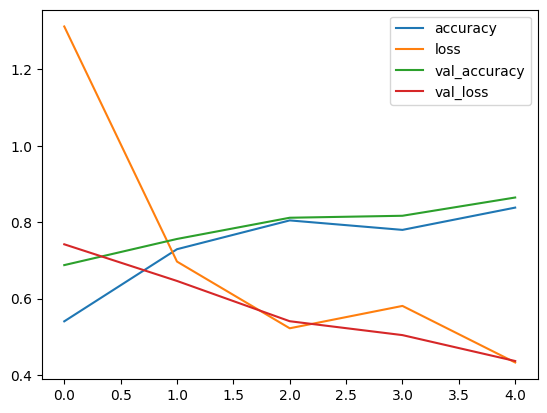

In [51]:
pd.DataFrame(results.history).plot();

In [52]:
summary = pd.DataFrame(mobilenet_model.history.history)
summary.head(15)

,accuracy,loss,val_accuracy,val_loss
0,0.540715,1.311784,0.687742,0.742155
1,0.729321,0.696968,0.756129,0.646322
2,0.804635,0.522526,0.811613,0.540994
3,0.779852,0.581000,0.816774,0.504677
4,0.838108,0.433106,0.864516,0.436931


In [53]:
preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

 1/25 ━━━━━━━━━━━━━━━━━━━━ 1:23 3s/step

W0000 00:00:1714720015.057087      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 516ms/step
[0 0 0 0 0 1 0 4 0 0 0 1 0 0 0 0 4 0 0 3 0 0 0 0 1 0 0 0 0 0 0 0 0 2 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 1 0 1 0 0 0 4 0 0 0 0 0 0 4 0 0 0 0
 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 1 1 2 0 0
 0 0 1 0 0 0 2 1 0 0 0 0 0 0 0 1 0 0 4 0 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 4 4 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 4 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 4 4
 2 2 2 2 2 2 2 2 4 2 2 4 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 4 2 2 2 2 2 2 2 2 2 2 2 2 4 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2 2 2
 2 2 2 2 2 4 2 4 2 2 2 4 2 2 2 4 2 2 2 2 2 2 2 2 4 2 2 2 2 2 2 2 2 2 4 2 2
 2 2 2 2 2 2 2 2 4 2 4 2 4 2 4 2 2 2 4 2 2 4 2 3 3 3 3 2 3

W0000 00:00:1714720027.439509      90 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


# **Model Comparison**

In [54]:
print('======CNN Model=========')

preds = model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

print('======Xception=========')

preds = xception_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

print('======MobileNetV2=========')

preds = mobilenet_model.predict(validation_data)
y_pred = np.argmax(preds, axis=1)
target_names = ['daisy','dandelion','rose','sunflower','tulip']
print(classification_report(validation_data.classes, y_pred, target_names= target_names))

======CNN Model=========
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 396ms/step
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       137
   dandelion       0.26      0.90      0.40       189
        rose       0.00      0.00      0.00       141
   sunflower       0.00      0.00      0.00       131
       tulip       0.35      0.23      0.28       177

    accuracy                           0.27       775
   macro avg       0.12      0.23      0.14       775
weighted avg       0.14      0.27      0.16       775

======Xception=========


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 404ms/step
              precision    recall  f1-score   support

       daisy       0.91      0.88      0.90       137
   dandelion       0.92      0.82      0.87       189
        rose       0.85      0.85      0.85       141
   sunflower       0.83      0.83      0.83       131
       tulip       0.80      0.90      0.85       177

    accuracy                           0.86       775
   macro avg       0.86      0.86      0.86       775
weighted avg       0.86      0.86      0.86       775

======MobileNetV2=========
25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step
              precision    recall  f1-score   support

       daisy       0.97      0.77      0.86       137
   dandelion       0.83      0.91      0.87       189
        rose       0.85      0.82      0.84       141
   sunflower       0.92      0.72      0.81       131
       tulip       0.72      0.90      0.80       177

    accuracy                           0.83       775
   macro avg       0